This Notebook contains an ECG classification approach using Convolutional Neural Network.

In [9]:
input_dir = "/Users/Giovanni/Desktop/Università/Magistrale/AIB/final-assignment/training_set_splitted/train"

In [10]:
import os

# list the data present in the dataset
dirs = sorted(os.listdir(input_dir))
print(dirs)

['S001_128.mat', 'S001_128_ann.mat', 'S001_128_rpk.mat', 'S002_128.mat', 'S002_128_ann.mat', 'S002_128_rpk.mat', 'S003_128.mat', 'S003_128_ann.mat', 'S003_128_rpk.mat', 'S004_128.mat', 'S004_128_ann.mat', 'S004_128_rpk.mat', 'S005_128.mat', 'S005_128_ann.mat', 'S005_128_rpk.mat', 'S006_128.mat', 'S006_128_ann.mat', 'S006_128_rpk.mat', 'S007_128.mat', 'S007_128_ann.mat', 'S007_128_rpk.mat', 'S008_128.mat', 'S008_128_ann.mat', 'S008_128_rpk.mat', 'S009_128.mat', 'S009_128_ann.mat', 'S009_128_rpk.mat', 'S010_128.mat', 'S010_128_ann.mat', 'S010_128_rpk.mat', 'S011_128.mat', 'S011_128_ann.mat', 'S011_128_rpk.mat', 'S012_128.mat', 'S012_128_ann.mat', 'S012_128_rpk.mat', 'S013_128.mat', 'S013_128_ann.mat', 'S013_128_rpk.mat', 'S014_128.mat', 'S014_128_ann.mat', 'S014_128_rpk.mat', 'S015_128.mat', 'S015_128_ann.mat', 'S015_128_rpk.mat', 'S016_128.mat', 'S016_128_ann.mat', 'S016_128_rpk.mat', 'S017_128.mat', 'S017_128_ann.mat', 'S017_128_rpk.mat', 'S018_128.mat', 'S018_128_ann.mat', 'S018_128_r

In [11]:
# environment setup
from scipy.io import loadmat
import numpy as np, os, sys, joblib
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
import pandas as pd
import random

#Setting random seed for reproducibility
#Remember to use always SEED for the functions that requires it (like Scikit models)
SEED = 1234
np.random.seed(SEED)
pd.core.common._random_stat = SEED
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

In [12]:
# Utility function to load data

def load_data(ecg_file):
  ecg = loadmat(ecg_file)
  rpk_file = ecg_file.replace('.mat', '_rpk.mat')
  rpk = loadmat(rpk_file)
  ann_file = ecg_file.replace('.mat', '_ann.mat')
  ann = loadmat(ann_file)
  return ecg, rpk, ann

In [13]:
# Get the ecg file for each sample and create a list of all ecgs
ecg_files = []

for f in dirs:
  g = input_dir+'/'+f
  if g.find('_ann') == -1 and g.find('_rpk') == -1:
   ecg_files.append(g)

num_files = len(ecg_files)
# Create lists that will contains each data types (ecg, labels, rpeaks) an filenames (a list which contains the original filename for each sample)
filenames = list()
ecgs = list()
rpks = list()
anns = list()

for i in range(num_files):
  ecg, rpk, ann = load_data(ecg_files[i])
  print(
        "\rLoading file: {}/{}"
            .format(i+1, num_files),
        end=""
    )
  ecgs.append(ecg)
  rpks.append(rpk)
  anns.append(ann)
  filenames.append(ecg_files[i])

#ecg = np.asarray(loadmat(g)['ecg'], dtype=np.float64)
#rpk = np.asarray(loadmat(input_dir + "/S083_250_rpk.mat")['rpeaks'], dtype=np.float64)
#ann = np.asarray(loadmat(input_dir + "/S083_250_ann.mat")['labels'])

Loading file: 90/90

In [14]:
! pip install neurokit2 tdqm

In [15]:
import neurokit2 as nk

In [16]:
# Utility: given the filename of a signal it returns the sampling frequency
def ecg_freq(filename):
  if '128' in filename:
    return 128
  else:
    return 250

In [17]:
# Try to extract each single heartbeat

# list of list that contains all heartbeats divided by patient
patient_heartbeats = []

for i in tqdm(range(len(ecgs))):
  # extract a sample ecgd
  ecg_sample = np.asarray(ecgs[i]['ecg'], dtype=np.float64)
  sampling = ecg_freq(filenames[i])
  #ecg_sample_= np.arange(0, ecg_sample.shape[0]/sampling, 1/sampling)
  # clean ecg_sample
  ecg_signal_l1 = nk.ecg_clean(ecg_sample[:,0], sampling_rate=sampling, method='neurokit2')
  
  #Extract peaks from traning set and their labels
  sample_rpeaks = rpks[i]['rpeaks'] 
  # Handling last beats (if last rpeak is >= to current ecg lenght, we remove it)
  add_padding=False
  if sample_rpeaks[-1] >= len(ecg_signal_l1):
    #sample_labels = sample_labels[:-1]
    sample_rpeaks = sample_rpeaks[:-1] 
    add_padding = True
  rpeaks = {'ECG_R_Peaks': sample_rpeaks.flatten(), 'sampling_rate': sampling}

  # extract heartbeats of current ecg
  ecg_heartbeats_l1 = nk.ecg_segment(ecg_cleaned=ecg_signal_l1, rpeaks=rpeaks['ECG_R_Peaks'], sampling_rate=sampling)

  if(add_padding == True): #If we cannot extract the last beat, we replicate the last good beat
   ecg_heartbeats_l1[str(int(list(ecg_heartbeats_l1.keys())[-1]) + 1)] = ecg_heartbeats_l1[list(ecg_heartbeats_l1.keys())[-1]]

  patient_heartbeats.append(ecg_heartbeats_l1)

100%|██████████| 90/90 [09:20<00:00,  6.22s/it]


In [18]:
#load the heartbeats inside an array
heartbeats = []

for p in range(len(patient_heartbeats)):
 for b in patient_heartbeats[p].keys():
  heartbeats.append(list(patient_heartbeats[p][b].Signal))

In [19]:
#removing nan values and substituting them with 0s
for i in range(len(heartbeats)):
    for j in range(len(heartbeats[i])):
        if(str(heartbeats[i][j]) == 'nan'):
            heartbeats[i][j] = 0

In [20]:
classes_name = ['N', 'S', 'V']

In [21]:
# list which contains all labels of each beat
all_labels = []

for sample in anns:
  for beat in sample['labels']:
    all_labels.append(beat)

In [22]:
print(len(all_labels))
print(len(heartbeats))

213024
213024


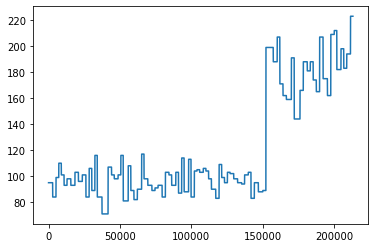

In [23]:
lengths = []
for b in heartbeats:
   lengths.append(len(b))

import matplotlib.pyplot as plt

plt.plot(lengths)

max_len = max(lengths)

In [24]:
import tensorflow as tf
#pad heartbeats in order to have the same dimension
heartbeats = tf.keras.preprocessing.sequence.pad_sequences(heartbeats, maxlen=max_len, dtype='float32', truncating='post',padding="post")

In [ ]:
#features = dict(patient_heartbeats = heartbeats, target = all_labels)

In [ ]:
#features_df = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in features.items() ]))

In [25]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(all_labels)

#One hot encoding of the target values
ohe = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
target_ohe = ohe.fit_transform(integer_encoded)

In [26]:
label_encoder.inverse_transform([0,1,2])

array(['N', 'S', 'V'], dtype='<U1')

In [27]:
ohe.inverse_transform([[1, 0, 0], [0,1,0], [0,0,1]])

array([[0],
       [1],
       [2]], dtype=int64)

In [28]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(heartbeats, target_ohe, test_size=0.2, random_state=SEED,
                               shuffle=True, stratify=target_ohe)

In [29]:
X_train = X_train.reshape(-1, max_len, 1)

X_val = X_val.reshape(-1, max_len, 1)


In [268]:
X_train.shape

(170419, 223, 1)

In [228]:
len(y_train)


170419

In [30]:
train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(16)
validation_data = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(16)

Now Let's define the model, a simple CNN with 1D convolution layers

In [137]:
import tensorflow as tf

cnn_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=16, kernel_size=3, padding='same',
                        activation=tf.nn.leaky_relu, input_shape=[max_len, 1]),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(filters=64, kernel_size=3,
                        padding='same', activation=tf.nn.leaky_relu),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(128, activation=tf.nn.leaky_relu),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(3, activation=tf.nn.softmax)
])

In [138]:
cnn_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_10 (Conv1D)           (None, 223, 16)           64        
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 111, 16)           0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 111, 64)           3136      
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 55, 64)            0         
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 64)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               8320      
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)              

In [139]:
learning_rate = 0.001
cnn_model.compile(
    optimizer = tf.keras.optimizers.Adam(),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy', tf.keras.metrics.Precision(),tf.keras.metrics.Recall()]
)

In [153]:
history = cnn_model.fit(train_data, 
    validation_data=validation_data,
    shuffle= True,
    epochs = 15,
).history

Epoch 1/10
10652/10652 [==============================] - 79s 7ms/step - loss: 0.1241 - accuracy: 0.9615 - precision_5: 0.9632 - recall_5: 0.9601 - val_loss: 0.1155 - val_accuracy: 0.9641 - val_precision_5: 0.9660 - val_recall_5: 0.9625
Epoch 2/10
10652/10652 [==============================] - 83s 8ms/step - loss: 0.1224 - accuracy: 0.9617 - precision_5: 0.9635 - recall_5: 0.9603 - val_loss: 0.1174 - val_accuracy: 0.9642 - val_precision_5: 0.9660 - val_recall_5: 0.9622
Epoch 3/10
10652/10652 [==============================] - 96s 9ms/step - loss: 0.1207 - accuracy: 0.9623 - precision_5: 0.9641 - recall_5: 0.9607 - val_loss: 0.1143 - val_accuracy: 0.9633 - val_precision_5: 0.9650 - val_recall_5: 0.9615
Epoch 4/10
10652/10652 [==============================] - 98s 9ms/step - loss: 0.1197 - accuracy: 0.9624 - precision_5: 0.9642 - recall_5: 0.9610 - val_loss: 0.1146 - val_accuracy: 0.9644 - val_precision_5: 0.9664 - val_recall_5: 0.9628
Epoch 5/10
10652/10652 [============================

KeyboardInterrupt: 

In [154]:
#Computing the prediction of the model on the validation set
predictions = []
for element in validation_data.as_numpy_iterator():
    predictions.append(cnn_model.predict(element[0]))

In [155]:
predictions_f = [item for sublist in predictions for item in sublist]

In [156]:
predictions_oh = []
#transform prediction into one-hot-encoding 
for i in range(len(predictions_f)):
    predictions_oh.append(tf.one_hot(tf.argmax(predictions_f[i]), depth=3))

In [157]:
#Compute the true and prediction array in order to plot the confusion matrix
y = []

for y_t in y_val.tolist():
    if(y_t == [1, 0, 0]):
        y.append('N')
    if(y_t == [0, 1 ,0]):
        y.append('S')
    if(y_t == [0, 0 ,1]):
        y.append('V')    

y_pred = []

for y_t in predictions_oh:
    if(all(tf.equal(y_t, tf.constant([1, 0, 0], dtype=np.float32)))):
        y_pred.append('N')
    elif(all(tf.equal(y_t, tf.constant([0, 1, 0], dtype=np.float32)))):
        y_pred.append('S')
    elif(all(tf.equal(y_t, tf.constant([0, 0, 1], dtype=np.float32)))):
        y_pred.append('V')  
    else:
        print(y_t)    

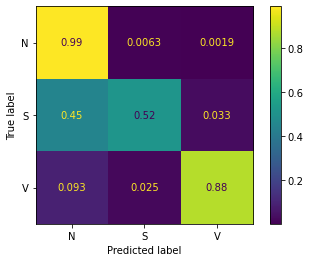

In [158]:
#Plotting the confusion matrix
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

ConfusionMatrixDisplay.from_predictions(y, y_pred, normalize='true', labels = ['N', 'S', 'V'])

In [159]:
print(classification_report(y,y_pred))

              precision    recall  f1-score   support

           N       0.98      0.99      0.98     39204
           S       0.77      0.52      0.62      1864
           V       0.91      0.88      0.90      1537

    accuracy                           0.97     42605
   macro avg       0.89      0.80      0.83     42605
weighted avg       0.96      0.97      0.96     42605

